In [7]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from elasticsearch import Elasticsearch
from faker import Faker

docker run -d \
  --name elastic \
  -p 9200:9200 \
  -e "discovery.type=single-node" \
  -v /home/apprenant/Documents/DEV_IA/NLP/NLP_Psy/Data:/usr/share/elasticsearch/data \
  docker.elastic.co/elasticsearch/elasticsearch:7.17.10


## Temps 2:  Stocker les données avec Elastic Search

### Mise en place
- Démarrer un container à partir de l’image docker.elastic.co/elasticsearch/elasticsearch:7.17.10
- en mode détaché -d
- monter le volume /usr/share/elasticsearch/data en local
- utiliser le mapping de port -p 9200:9200
- utiliser la variable -e "discovery.type=single-node"
- le nom du container sera --name elastic

- Visualiser les logs du container 
- appeler la route racine “/”


docker run -d --name elastic -p 9200:9200 -e "discovery.type=single-node" -v NLP_Psy/Data docker.elastic.co/elasticsearch/elasticsearch:7.17.10


docker run -d --name elastic 
-p 9200:9200 
-e "discovery.type=single-node" 
-v /home/apprenant/Documents/DEV_IA/NLP/NLP_Psy:/usr/share/elasticsearch/data docker.elastic.co/elasticsearch/elasticsearch:7.17.10


docker logs elastic

curl -X GET http://localhost:9200/


### Mapper et importer les données


Poster le mapping d’un index nommé “notes”, contenant :

- champ “patient_lastname” qui est un term
- champ “patient_firstname” qui est un term
- champ “text”, texte analysé en standard
- champ “date”, qui est une date
- champ “patient_left”, qui est un booléen
- champ “emotion”, qui est un term
- champ ‘confidence” qui est un float

Alimenter l’index “notes” à l’aide du jeu de données et de la librairie Faker. 

Bonus: Mettez en place un pipeline utilisant le modèle TF-IDF que vous avez développé avec scikit-learn pour remplir l- champs “emotion” et “confidence”.


In [13]:
es = Elasticsearch(hosts=["http://localhost:9200"])
es.transport.close()

#### Creation de notes

In [8]:

# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Mapping de l'index "notes"
mapping = {
    "mappings": {
        "properties": {
            "patient_lastname": {"type": "keyword"},
            "patient_firstname": {"type": "keyword"},
            "text": {"type": "text", "analyzer": "standard"},
            "date": {"type": "date"},
            "patient_left": {"type": "boolean"},
            "emotion": {"type": "keyword"},
            "confidence": {"type": "float"}
            
        }
    }
}

# Création de l'index avec le mapping
index_name = "notes2"
es.indices.create(index=index_name, body=mapping)
es.transport.close()


/tmp/ipykernel_3892/931160315.py:22: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index=index_name, body=mapping)
/tmp/ipykernel_3892/931160315.py:22: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index=index_name, body=mapping)


#### Remplissage de notes avec 150 personnes fictives


In [10]:

# Définition du nom de l'index
index_name = "notes2"

# Lecture du fichier CSV
df = pd.read_csv("Emotion_data.csv")

# Génération des noms/prénoms uniques
fake = Faker()
clients = list(set(fake.name() for _ in range(150)))

# Mélange aléatoire des clients
random.shuffle(clients)

# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Alimentation de l'index "notes"
for index, row in df.iterrows():
    # Sélection aléatoire d'un client parmi les 150
    client = clients[index % 150]

    doc = {
        "patient_lastname": row['patient_name'],  # Nom de famille
        "patient_firstname": row['patient_lastname'],  # Prénom
        "text": row["text"],
        "emotion": row["predicted"],
        "date": fake.date(),
        "patient_left": fake.boolean(),
        "confidence": row['confidence']
    }
    es.index(index=index_name, body=doc)

# Fermeture de la connexion à Elasticsearch
es.transport.close()


/tmp/ipykernel_3892/953512353.py:31: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index=index_name, body=doc)
/tmp/ipykernel_3892/953512353.py:31: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.index(index=index_name, body=doc)


#### Requetage de notes

In [11]:

# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Index et requête
index_name = "notes2"
query = {
  "query": {
    "match_all": {}  # Requête pour récupérer tous les documents
  },
  "size": 10000  # Définir la taille de pagination pour récupérer tous les documents
}

# Exécution de la requête
response = es.search(index=index_name, body=query)

# Traitement des résultats
for hit in response["hits"]["hits"]:
    source = hit["_source"]
    # Récupérer les champs souhaités et les afficher
    patient_firstname = source["patient_firstname"]
    patient_lastname = source["patient_lastname"]
    text = source["text"]
    date = source["date"]
    confidence = source["confidence"]
    emotion = source["emotion"]
    patient_left = source["patient_left"]

    print("Patient:", patient_firstname, patient_lastname)
    print("Text:", text)
    print("Date:", date)
    print("Confidence:", confidence)
    print("Emotion:", emotion)
    print("Patient Left:", patient_left)
    print("---")



/tmp/ipykernel_3892/3339344000.py:14: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=query)
/tmp/ipykernel_3892/3339344000.py:14: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=query)


Patient: Angela Dr.
Text: i didnt feel humiliated
Date: 1991-04-19
Confidence: 0.35
Emotion: neutral
Patient Left: False
---
Patient: Oliver Marisa
Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Date: 1981-10-28
Confidence: 0.89
Emotion: optimism
Patient Left: True
---
Patient: Garcia Joshua
Text: im grabbing a minute to post i feel greedy wrong
Date: 2004-02-09
Confidence: 0.32
Emotion: disappointment
Patient Left: True
---
Patient: Johnson Jack
Text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Date: 1996-07-10
Confidence: 0.5
Emotion: neutral
Patient Left: True
---
Patient: Rivera David
Text: i am feeling grouchy
Date: 1986-09-15
Confidence: 0.58
Emotion: sadness
Patient Left: True
---
Patient: Schaefer Daniel
Text: ive been feeling a little burdened lately wasnt sure why that was
Date: 1994-03-26
Confidence: 0.61
Emotion: confusion
Patient Left: True
---
Patient: Case

### Creation du dataframe a partir d'ElasticSearch.

In [49]:

index_name = "notes"
query = {
  "query": {
    "match_all": {}  # Requête pour récupérer tous les documents
  },
  "size": 10000  # Définir la taille de pagination pour récupérer tous les documents
}

# Exécution de la requête
response = es.search(index=index_name, body=query)

# Liste pour stocker les données du patient
patient_data = []

# Traitement des résultats
for hit in response["hits"]["hits"]:
    source = hit["_source"]
    # Récupérer les champs souhaités et les ajouter à la liste
    patient_firstname = source["patient_firstname"]
    patient_lastname = source["patient_lastname"]
    text = source["text"]
    date = source["date"]
    confidence = source["confidence"]
    emotion = source["emotion"]
    patient_left = source["patient_left"]

    patient_data.append({
        "Patient Firstname": patient_firstname,
        "Patient Lastname": patient_lastname,
        "Text": text,
        "Date": date,
        "Confidence": confidence,
        "Emotion": emotion,
        "Patient Left": patient_left
    })

# Créer un DataFrame à partir des données du patient
df = pd.DataFrame(patient_data)

# Afficher la répartition des sentiments des textes pour le patient
emotion_counts = df.groupby(["Patient Firstname", "Patient Lastname", "Emotion"]).size().reset_index(name="Count")

# Afficher la répartition des émotions pour chaque patient unique
emotion_counts


/tmp/ipykernel_6305/1805460334.py:10: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=query)
/tmp/ipykernel_6305/1805460334.py:10: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=query)


,Patient Firstname,Patient Lastname,Emotion,Count
0,Aaron,Kelley,anger,7
1,Aaron,Kelley,fear,11
2,Aaron,Kelley,happy,25
3,Aaron,Kelley,love,6
4,Aaron,Kelley,sadness,17
...,...,...,...,...
879,Vanessa,Hill,fear,9
880,Vanessa,Hill,happy,18
881,Vanessa,Hill,love,4
882,Vanessa,Hill,sadness,23


In [53]:
emotion_counts = df.groupby(['Patient Firstname', 'Patient Lastname', 'Emotion']).size().reset_index(name='Count')

# Pivoter le DataFrame pour avoir une ligne par patient et les émotions en colonnes
df_pivot = emotion_counts.pivot_table(index=['Patient Firstname', 'Patient Lastname'], columns='Emotion', values='Count', fill_value=0)

# Réinitialiser les index pour avoir des colonnes normales au lieu de MultiIndex
df_pivot.reset_index(inplace=True)

# Renommer la colonne des patients

# Afficher le DataFrame pivoté
df_pivot    

Emotion,Patient Firstname,Patient Lastname,anger,fear,happy,love,sadness,surprise
0,Aaron,Kelley,7,11,25,6,17,1
1,Adrienne,Ball,4,11,24,4,24,0
2,Alyssa,Brown,8,5,20,6,22,5
3,Amanda,Hayes,8,7,25,7,20,0
4,Amber,Reed,9,10,19,9,16,4
...,...,...,...,...,...,...,...,...
145,Tina,Deleon,5,10,27,9,13,3
146,Toni,Moreno,10,7,21,2,21,6
147,Tracy,Cooper,6,7,23,4,25,2
148,Tyler,Long,4,8,27,2,24,1


In [54]:
# # Connexion à Elasticsearch
# es = Elasticsearch(hosts=["http://localhost:9200"])

# # Suppression de l'index "notes"
# index_name = "notes"
# response = es.indices.delete(index=index_name, ignore=[400, 404])

# # Vérification de la suppression
# if response["acknowledged"]:
#     print(f"L'index '{index_name}' a été supprimé avec succès.")
# else:
#     print(f"La suppression de l'index '{index_name}' a échoué.")

# # Fermeture de la connexion à Elasticsearch
# es.transport.close()


#### Matrice de Sentiments COntradictoires

2- Élaborez une matrice de sentiments contradictoire (toujours en utilisant la base elastic search.
- On veut savoir parmi les documents classifiés comme happy, quel pourcentage contient le mot “sadness”. Puis quel pourcentage contient “fear” etc.
- Et cela pour tous les sentiment.
- On représente les résultats dans une HeatMap


/tmp/ipykernel_6305/587906593.py:14: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=query)
/tmp/ipykernel_6305/587906593.py:14: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=query)


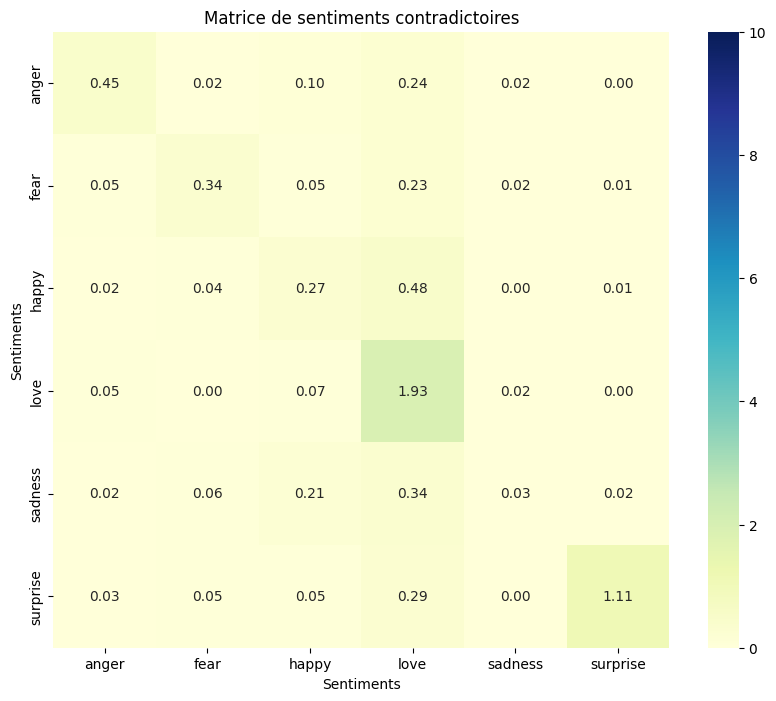

In [65]:
# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Index et requête
index_name = "notes"
query = {
  "query": {
    "match_all": {}  # Requête pour récupérer tous les documents
  },
  "size": 10000  # Définir la taille de pagination pour récupérer tous les documents
}

# Exécution de la requête
response = es.search(index=index_name, body=query)

# Liste pour stocker les données des documents
document_data = []

# Traitement des résultats
for hit in response["hits"]["hits"]:
    source = hit["_source"]
    # Récupérer les champs souhaités et les ajouter à la liste
    text = source["text"]
    emotion = source["emotion"]
    document_data.append({
        "Text": text,
        "Emotion": emotion
    })

# Créer un DataFrame à partir des données des documents
df = pd.DataFrame(document_data)

# Liste des sentiments à considérer
sentiments = ["anger", "fear", "happy", "love", "sadness", "surprise"]

# Créer une matrice pour stocker les pourcentages de sentiments contradictoires
matrix = pd.DataFrame(index=sentiments, columns=sentiments)

# Calculer les pourcentages de sentiments contradictoires
for sentiment1 in sentiments:
    for sentiment2 in sentiments:
        count = df[df["Emotion"] == sentiment1]["Text"].str.contains(sentiment2).sum()
        total = df[df["Emotion"] == sentiment1].shape[0]
        percentage = count / total * 10  # Échelle de 0 à 10
        matrix.loc[sentiment1, sentiment2] = percentage

# Convertir les valeurs de la matrice en nombres à virgule flottante
matrix = matrix.astype(float)

# Afficher la HeatMap avec échelle de 0 à 10
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, square=True, vmin=0, vmax=10)
plt.title("Matrice de sentiments contradictoires")
plt.xlabel("Sentiments")
plt.ylabel("Sentiments")
plt.show()


#### 3- Pour chacune des étapes du deuil (denial, anger, bargaining, depression, and acceptance) rechercher le nombre de text correspondants à l’aide:
- d’une recherche pleine
- d’une fuzzy recherche.


##### Ful-text search (rechzerche pleine)

In [66]:

# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Étape du deuil
stages = ["denial", "anger", "bargaining", "depression", "acceptance"]

# Effectuer une recherche pleine pour chaque étape
for stage in stages:
    query = {
        "query": {
            "match": {
                "text": stage
            }
        }
    }
    result = es.search(index="notes", body=query)
    count = result["hits"]["total"]["value"]
    print(f"Nombre de textes correspondants à l'étape '{stage}': {count}")

# Fermer la connexion Elasticsearch
es.transport.close()


Nombre de textes correspondants à l'étape 'denial': 2
Nombre de textes correspondants à l'étape 'anger': 66
Nombre de textes correspondants à l'étape 'bargaining': 0
Nombre de textes correspondants à l'étape 'depression': 23
Nombre de textes correspondants à l'étape 'acceptance': 9


/tmp/ipykernel_6305/3993909605.py:16: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="notes", body=query)
/tmp/ipykernel_6305/3993909605.py:16: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", body=query)


##### Fuzzy serch (recherche flou)

In [67]:

es = Elasticsearch(hosts=["http://localhost:9200"])

# Étape du deuil
stages = ["denial", "anger", "bargaining", "depression", "acceptance"]

# Effectuer une recherche floue pour chaque étape
for stage in stages:
    query = {
        "query": {
            "match": {
                "text": {
                    "query": stage,
                    "fuzziness": "AUTO"
                }
            }
        }
    }
    result = es.search(index="notes", body=query)
    count = result["hits"]["total"]["value"]
    print(f"Nombre de textes correspondants (recherche floue) à l'étape '{stage}': {count}")

# Fermer la connexion Elasticsearch
es.transport.close()


Nombre de textes correspondants (recherche floue) à l'étape 'denial': 119
Nombre de textes correspondants (recherche floue) à l'étape 'anger': 82
Nombre de textes correspondants (recherche floue) à l'étape 'bargaining': 0
Nombre de textes correspondants (recherche floue) à l'étape 'depression': 84
Nombre de textes correspondants (recherche floue) à l'étape 'acceptance': 71


/tmp/ipykernel_6305/4169426695.py:21: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="notes", body=query)
/tmp/ipykernel_6305/4169426695.py:21: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", body=query)


#### 4- Rechercher les textes:
- qui doivent matcher l’expression “good day” (must)
- chez les patients encore en consultation (filter)
- qui contiennent si possible “to rest” (should)
- qui ne doivent pas avoir seuil de confiance inférieur à 0.5 s’il existe. 
- Observer la répartition de ces résultats par sentiment


In [80]:
# Connexion à Elasticsearch
es = Elasticsearch(hosts=["http://localhost:9200"])

# Requête de recherche
query = {
    "query": {
        "bool": {
            "must": {
                "match_phrase": {
                    "text": "good day"
                }
            },
            "filter": {
                "term": {
                    "patient_left": False
                }
            },
            "should": {
                "match": {
                    "text": "to rest"
                }
            },
            "must_not": {
                "range": {
                    "confidence": {
                        "lt": 0.5
                    }
                }
            }
        }
    },
    "aggs": {
        "sentiment_distribution": {
            "terms": {
                "field": "emotion"
            }
        }
    }
}

# Effectuer la recherche
result = es.search(index="notes", body=query)

# Récupérer les résultats et la répartition par sentiment
hits = result["hits"]["hits"]
sentiment_distribution = result["aggregations"]["sentiment_distribution"]["buckets"]

# Afficher les résultats
print(f"Nombre total de textes correspondants : {len(hits)}")
print("Résultats :")
for hit in hits:
    print(f"- {hit['_source']['text']}")

# Afficher la répartition par sentiment
print("\nRépartition par sentiment :")
for bucket in sentiment_distribution:
    print(f"- Sentiment '{bucket['key']}': {bucket['doc_count']}")

# Fermer la connexion Elasticsearch
es.transport.close()


Nombre total de textes correspondants : 1
Résultats :
- i had a good day but right now im feeling pretty irritable for no real reason meaning nothing significant happened to make me feel annoyed

Répartition par sentiment :
- Sentiment 'anger': 1


/tmp/ipykernel_6305/347072161.py:42: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index="notes", body=query)
/tmp/ipykernel_6305/347072161.py:42: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", body=query)


##### Questions théoriques

- Relire le cours sur Elastic Search à l’aide de nos nouvelles connaissance et répondre aux questions:
- Qu’est ce que le sharding, comment pourrait-on imaginer un sharding sur cet index?
- Quels ingestion pipelines seraient pertinents pour notre sujet.
